In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import pickle
from sklearn.externals import joblib

# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')


In [16]:
svc=joblib.load(open('svc.pkl', 'rb'))
X_scaler=joblib.load(open('X_scaler.pkl', 'rb'))


In [17]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


In [18]:
def pipeline_window(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/256
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[image.shape[0]/2,image.shape[0]], 
                        xy_window=(192,192), xy_overlap=(0.75,0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[image.shape[0]/2,image.shape[0]*3/4], 
                        xy_window=(96,96), xy_overlap=(0.75,0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img

def pipeline_heat(hot_windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    return heat
def pipeline_label(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/256
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[image.shape[0]/2,image.shape[0]], 
                        xy_window=(192,192), xy_overlap=(0.75,0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[image.shape[0]/2,image.shape[0]*3/4], 
                        xy_window=(96,96), xy_overlap=(0.75,0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img


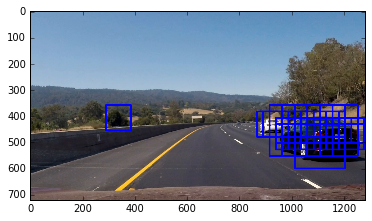

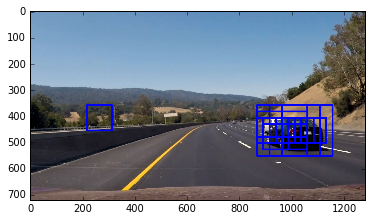

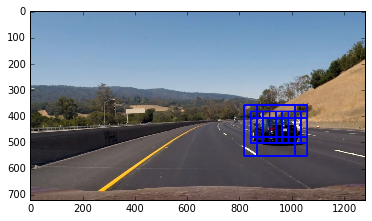

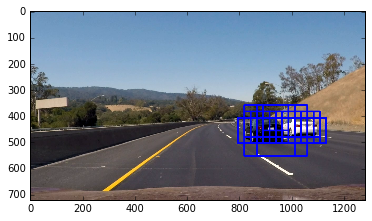

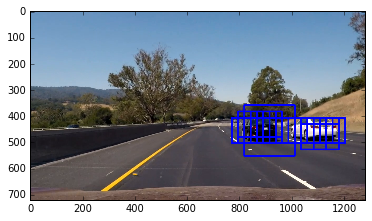

In [19]:
from moviepy.editor import VideoFileClip
for i in range(30,40,2):
    clip1 = VideoFileClip('project_video.mp4').get_frame(i)
    window_img = pipeline_window(clip1)
    plt.imshow(window_img)
    plt.show()


In [9]:
from moviepy.editor import VideoFileClip
video_file = 'project_video.mp4'
subclip = VideoFileClip(video_file).subclip(22,23)
white_clip = subclip.fl_image(pipeline_window)
white_clip.write_videofile('output/'+video_file.split('/')[-1], audio=False)


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


 96%|█████████▌| 25/26 [01:13<00:02,  2.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 



400